<a href="https://www.kaggle.com/code/hamedetezadi/intel-imageclassification?scriptVersionId=91515494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

In [2]:
# Listing directory
!ls ../input/intel-image-dataset/Intel Image Dataset"

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


Let's visualize some of the mountain images that we will be working on. Also we will observe x and y dimensions of the image.

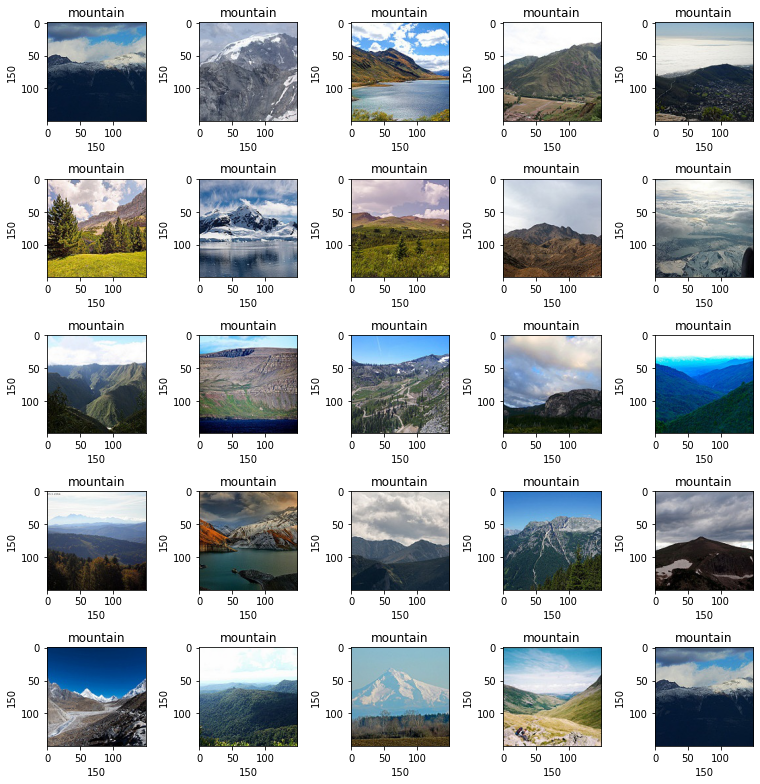

In [3]:
# Plotting 25 images to check dataset

plt.figure(figsize=(11,11))
path ="../input/intel-image-dataset/Intel Image Dataset/mountain"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('mountain')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

Setting the root directory for the dataset and storing all the folders name of the dataset. We will also create 2 empty list for image and lables.


In [4]:
# Setting root directory path and creating empty list
from os import listdir
dir = "../input/intel-image-dataset/Intel Image Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

Next we need to resize images as some of the images don't have same dimensions. So, we will read and resize all the images. Then we will convert it into array and appending the list created above with the image and its label.

In [5]:
# Reading and converting image to numpy array

from PIL import Image



for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [6]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64

In [7]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

In [8]:
# Checking x data shape
np.array(image_list).shape

(3000, 150, 150, 3)

In [9]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3000,)

In [10]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [11]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

Here we will use label binarizer to one hot encode our y data. We will also print the sequence of the classes.


In [12]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [13]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Now we will create a network architecture for the model. We have used different types of layers according to their features namely BatchNormalization (Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch), LeakyRelu (The Leaky ReLU modifies the function to allow small negative values when the input is less than zero), Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel). In the last layer we will use softmax as the activation function because it is a multi class classification problem.

In [14]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

2022-03-29 05:37:19.131312: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0

In [15]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 70 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.


In [16]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

2022-03-29 05:37:20.923565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
15/15 [==============================] - 34s 2s/step - loss: 1.5653 - accuracy: 0.3901 - val_loss: 1.8209 - val_accuracy: 0.1562
Epoch 2/70
15/15 [==============================] - 30s 2s/step - loss: 1.1975 - accuracy: 0.5266 - val_loss: 1.9775 - val_accuracy: 0.1458
Epoch 3/70
15/15 [==============================] - 30s 2s/step - loss: 1.0829 - accuracy: 0.5880 - val_loss: 2.3498 - val_accuracy: 0.1479
Epoch 4/70
15/15 [==============================] - 30s 2s/step - loss: 1.0078 - accuracy: 0.6396 - val_loss: 2.3179 - val_accuracy: 0.1479
Epoch 5/70
15/15 [==============================] - 30s 2s/step - loss: 0.9290 - accuracy: 0.6745 - val_loss: 2.5219 - val_accuracy: 0.1479
Epoch 6/70
15/15 [==============================] - 30s 2s/step - loss: 0.8479 - accuracy: 0.7151 - val_loss: 2.7383 - val_accuracy: 0.1479
Epoch 7/70
15/15 [==============================] - 30s 2s/step - loss: 0.7988 - accuracy: 0.7427 - val_loss: 2.9130 - val_accuracy: 0.1479
Epoch 8/70
15/15 [==

In [17]:
# Saving model
model.save("intel_image.h5")

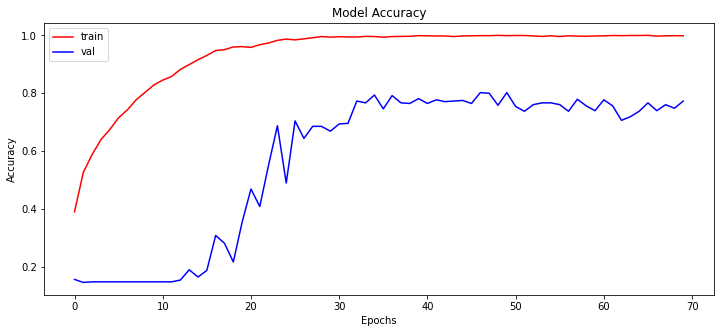

In [18]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

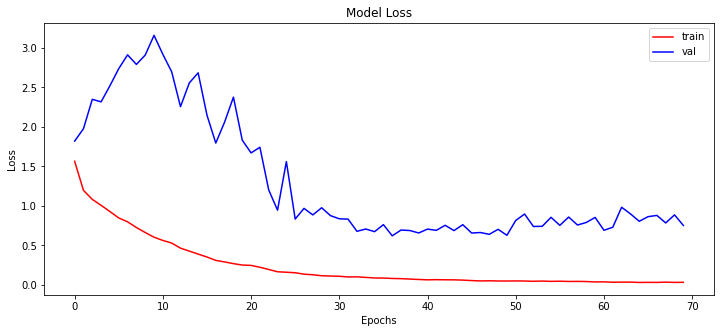

In [19]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [20]:
# Calculating test accuracy 
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 [==============================] - 3s 131ms/step - loss: 0.9335 - accuracy: 0.7283
Test Accuracy: 72.83333539962769


In [21]:
# Storing model predictions
y_pred = model.predict(x_test)

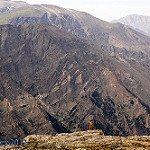

In [22]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

Now, we will create list of labels using object of label binarizer. We will print that list and finally we will print out the prediction and the original label of the image we visualized above using argmax().

In [23]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Originally :  mountain
Predicted :  glacier


## Conclusion:

In this project we saw how we can create a CNN using different layers. Normalizing is an important step when working with any type of dataset. We will use this model to predict the class of the image supplied to the model.